<h2>Importing the libraries</h2>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Anupam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<h2> Download Historical Stock Prices</h2>

In [2]:
ticker = "^BSESN"  # SENSEX ticker symbol
data = yf.download(ticker, start="2001-01-02", end="2022-03-31")
data.to_csv("sensex_historical_prices.csv")


[*********************100%%**********************]  1 of 1 completed


<h2>Load and Preprocess News Data</h2>

In [3]:
news_data = pd.read_csv("india-news-headlines.csv")
news_data['publish_date'] = pd.to_datetime(news_data['publish_date'], format='%Y%m%d')

sia = SentimentIntensityAnalyzer()
news_data['sentiment'] = news_data['headline_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
daily_sentiment = news_data.groupby('publish_date')['sentiment'].mean().reset_index()
daily_sentiment.set_index('publish_date', inplace=True)
news_data.head()

,publish_date,headline_category,headline_text,sentiment
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...,0.2924
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit,0.0000
2,2001-01-02,unknown,America's unwanted heading for India?,-0.2263
3,2001-01-02,unknown,For bigwigs; it is destination Goa,0.0000
4,2001-01-02,unknown,Extra buses to clear tourist traffic,0.3818


<h2>Merge Historical Prices and Sentiment Data</h2>

In [4]:
historical_prices = pd.read_csv("sensex_historical_prices.csv", index_col='Date', parse_dates=True)
full_date_range = pd.date_range(start=historical_prices.index.min(), end=historical_prices.index.max(), freq='B')
historical_prices = historical_prices.reindex(full_date_range)
historical_prices = historical_prices.fillna(method='ffill')
merged_data = historical_prices.merge(daily_sentiment, left_index=True, right_index=True, how='left')
merged_data['sentiment'].fillna(0, inplace=True)
merged_data.to_csv("merged_data.csv")
merged_data.head()

C:\Users\Anupam\AppData\Local\Temp\ipykernel_23352\4059934993.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_prices = historical_prices.fillna(method='ffill')


,Open,High,Low,Close,Adj Close,Volume,sentiment
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0,-0.018231
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0,-0.014800
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0,0.009842
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0,0.028646
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0,-0.055812


<h2>Train ARIMA Model</h2>

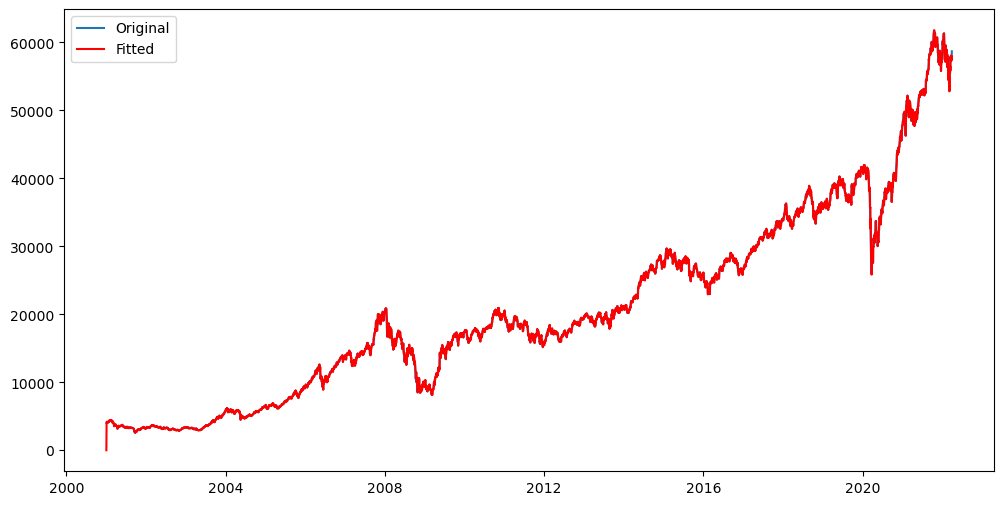

In [5]:
arima_model = ARIMA(merged_data['Close'], order=(5, 1, 0))
arima_result = arima_model.fit()

plt.figure(figsize=(12, 6))
plt.plot(merged_data['Close'], label='Original')
plt.plot(arima_result.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.show()

<h2>Prepare Data for LSTM</h2>

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[['Close', 'sentiment']])

lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<h2>Train LSTM Model</h2>

C:\Users\Anupam\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 6.1593e-04 - val_loss: 0.0040
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 6.1320e-04 - val_loss: 0.0017
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 4.5062e-04 - val_loss: 5.2220e-04
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 4.3248e-04 - val_loss: 0.0016
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 4.8822e-04 - val_loss: 0.0014
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 3.9311e-04 - val_loss: 0.0017
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 3.5493e-04 - val_loss: 0.0018
Epoch 9/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 3.4597e-04 - val_loss: 3.8431e-04
Epoch 10/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 3.0906e-04 - val_loss: 3.7767e-04
Epoch 11/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 2.8369e-04 - val_l

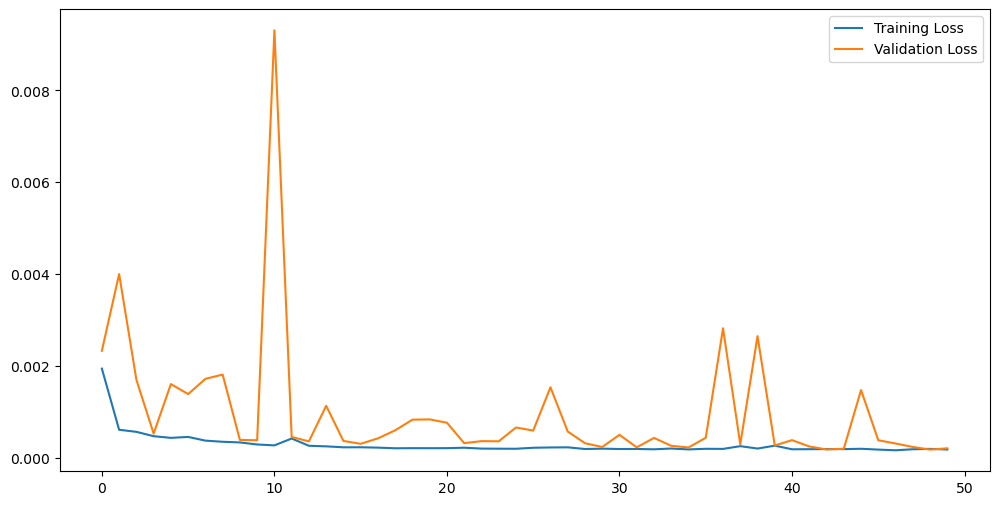

In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

<h2>Make Predictions and Evaluate</h2>

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


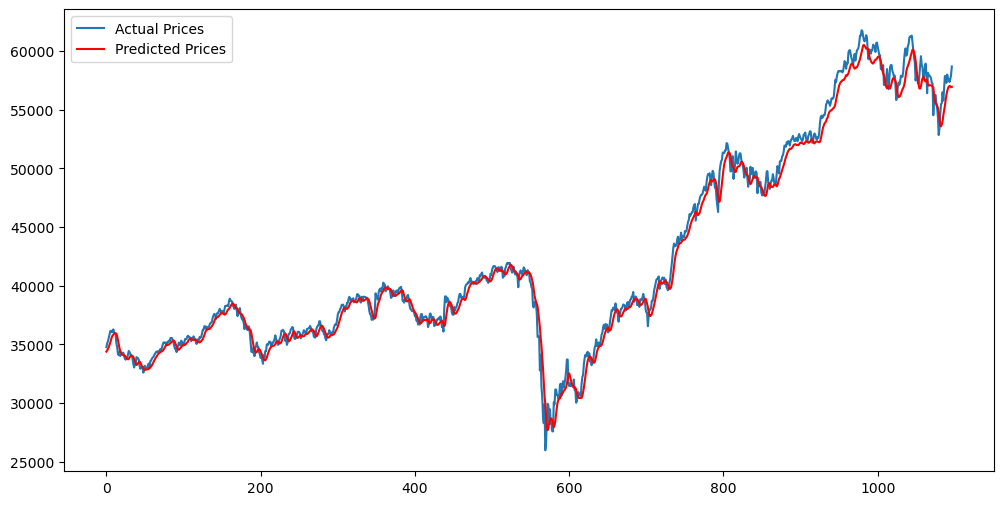

In [8]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], 1))), axis=1))[:, 0]
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.legend()
plt.show()

<h2>Calculating MAE and RMSE for both the models</h2>

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
arima_predictions = arima_result.predict(start=lookback, end=len(merged_data)-1, typ='levels')
arima_mae = mean_absolute_error(merged_data['Close'][lookback:], arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(merged_data['Close'][lookback:], arima_predictions))

print(f"ARIMA Model MAE: {arima_mae}")
print(f"ARIMA Model RMSE: {arima_rmse}")

ARIMA Model MAE: 169.63000293456045
ARIMA Model RMSE: 280.8538601203419


In [10]:
lstm_mae = mean_absolute_error(actual_prices, predicted_prices)
lstm_rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print(f"LSTM Model MAE: {lstm_mae}")
print(f"LSTM Model RMSE: {lstm_rmse}")


LSTM Model MAE: 632.8832125453321
LSTM Model RMSE: 841.1447847292411


<h2>Hyperparameter Tuning for increasing accuracy</h2>

C:\Users\Anupam\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Anupam\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Anupam\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Anupam\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Anupam\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax

Best ARIMA(0, 1, 2) MAE=167.8873005095238
Improved ARIMA Model MAE: 169.06036648441622
Improved ARIMA Model RMSE: 281.3864692299708


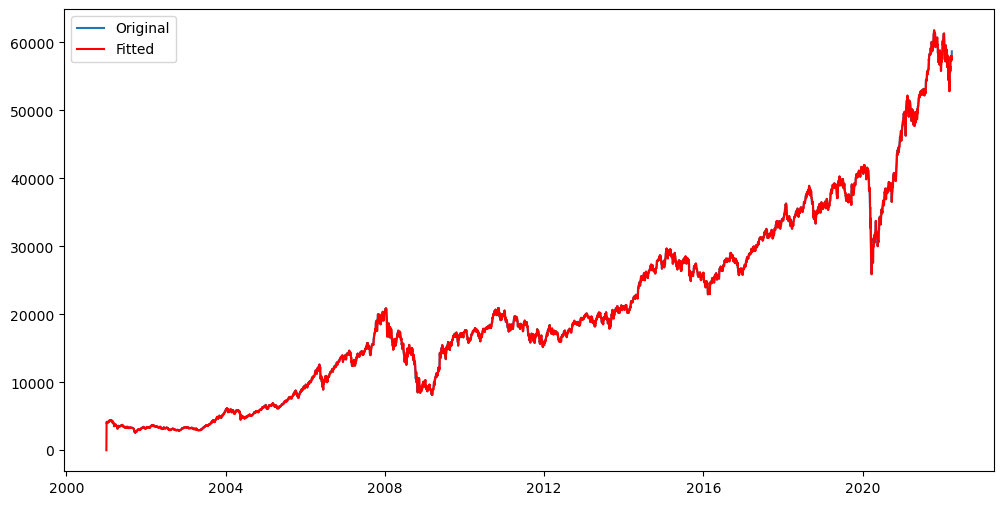

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define a function to perform grid search for ARIMA parameters
def arima_grid_search(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(data, order=(p, d, q))
                    model_fit = model.fit()
                    mae = mean_absolute_error(data[d:], model_fit.fittedvalues[d:])
                    if mae < best_score:
                        best_score, best_cfg = mae, (p, d, q)
                except:
                    continue
    print(f'Best ARIMA{best_cfg} MAE={best_score}')
    return best_cfg

# Perform grid search for ARIMA parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
best_cfg = arima_grid_search(merged_data['Close'], p_values, d_values, q_values)

# Train the best ARIMA model
arima_model = ARIMA(merged_data['Close'], order=best_cfg)
arima_result = arima_model.fit()

# Predictions for ARIMA model
arima_predictions = arima_result.predict(start=lookback, end=len(merged_data)-1, typ='levels')

# Calculate and display ARIMA model accuracy
arima_mae = mean_absolute_error(merged_data['Close'][lookback:], arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(merged_data['Close'][lookback:], arima_predictions))

print(f"Improved ARIMA Model MAE: {arima_mae}")
print(f"Improved ARIMA Model RMSE: {arima_rmse}")

# Plot the ARIMA model results
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Close'], label='Original')
plt.plot(arima_result.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.show()

Epoch 1/100


C:\Users\Anupam\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0119 - val_loss: 0.0012
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 4.0629e-04 - val_loss: 5.3496e-04
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 3.7511e-04 - val_loss: 0.0011
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 4.3047e-04 - val_loss: 6.4668e-04
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 3.2849e-04 - val_loss: 8.4624e-04
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 2.8339e-04 - val_loss: 4.1930e-04
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 3.1849e-04 - val_loss: 8.7083e-04
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 2.7403e-04 - val_loss: 5.1093e-04
Epoch 9/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 2.9596e-04 - val_loss: 3.6639e-04
Epoch 10/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 2.7759e-04 - val_loss: 4.4460e-04
Epoch 11/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss:

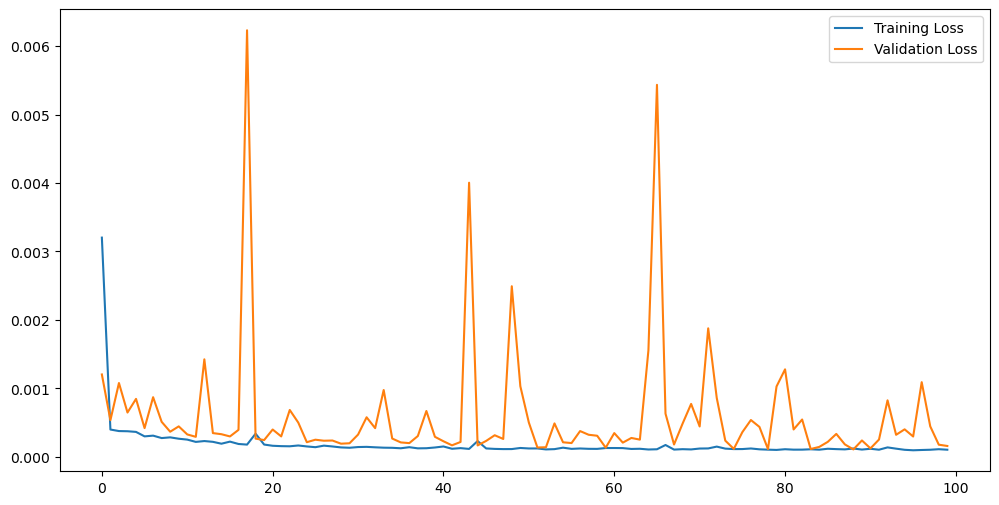

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
Improved LSTM Model MAE: 540.2297851851448
Improved LSTM Model RMSE: 743.7666062668358


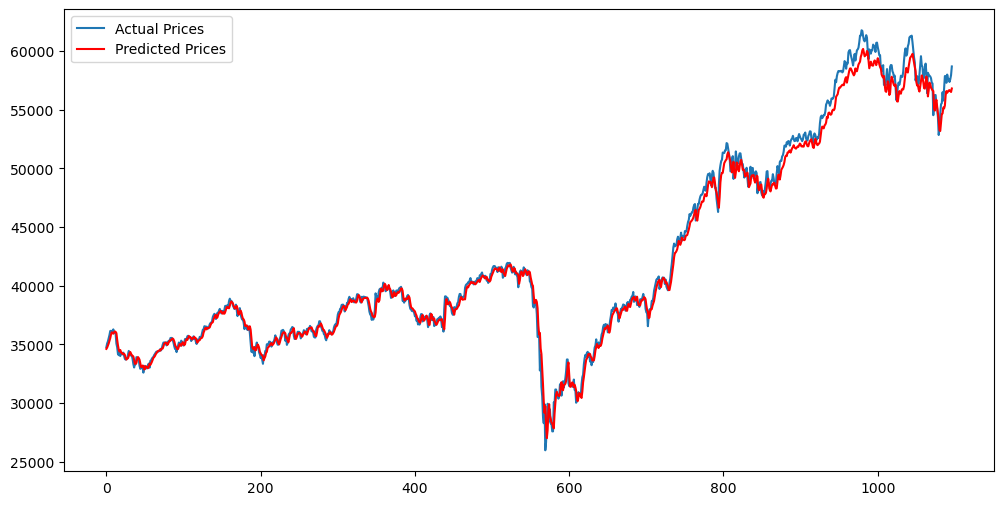

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Feature engineering: Adding moving averages
merged_data['MA7'] = merged_data['Close'].rolling(window=7).mean()
merged_data['MA21'] = merged_data['Close'].rolling(window=21).mean()
merged_data.fillna(0, inplace=True)

# Prepare data for LSTM
features = ['Close', 'sentiment', 'MA7', 'MA21']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[features])

lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train LSTM Model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Make predictions and evaluate
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], len(features)-1))), axis=1))[:, 0]
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1))), axis=1))[:, 0]

# Calculate and display LSTM model accuracy
lstm_mae = mean_absolute_error(actual_prices, predicted_prices)
lstm_rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print(f"Improved LSTM Model MAE: {lstm_mae}")
print(f"Improved LSTM Model RMSE: {lstm_rmse}")

# Plot the predictions against the actual prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.legend()
plt.show()
